<a href="https://colab.research.google.com/github/schukinam/otus_dl/blob/master/lesson2_pytorch_log_reg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [0]:
# параметры распределений
d0_mu0, d0_mu1, d0_sigma0, d0_sigma1, d0_sigma01 = -2., -3., 2., 3., 1.
d1_mu0, d1_mu1, d1_sigma0, d1_sigma1, d1_sigma01 = 3., 2., 2., 1., 1.

In [0]:
def cov_matrix(sigma0, sigma1, sigma01):
    return torch.tensor([[sigma0*sigma0, sigma01], [sigma01, sigma1*sigma1]])

In [0]:
d0 = torch.distributions.MultivariateNormal(torch.tensor([d0_mu0, d0_mu1]), 
                                            cov_matrix(d0_sigma0, d0_sigma1, d0_sigma01))
d1 = torch.distributions.MultivariateNormal(torch.tensor([d1_mu0, d1_mu1]), 
                                            cov_matrix(d1_sigma0, d1_sigma1, d1_sigma01))

In [0]:
def sample(d0, d1, n=32):
    x0 = d0.sample((n,))
    x1 = d1.sample((n,))
    y0 = torch.zeros((n, 1))
    y1 = torch.ones((n, 1))
    return torch.cat([x0, x1], 0), torch.cat([y0, y1], 0)

In [6]:
layer = nn.Linear(2, 1)
print([p.data[0] for p in layer.parameters()])
layer_opt = optim.SGD(lr=1e-3, params=list(layer.parameters()))

[tensor([ 0.6612, -0.6893]), tensor(0.3573)]


In [7]:
log_freq = 500
for i in range(10000):
    if i%log_freq == 0:
        with torch.no_grad():
            x, y = sample(d0, d1, 100000)
            out = torch.sigmoid(layer(x))
            loss = F.binary_cross_entropy(out, y)
        print('Ошибка после %d итераций: %f' %(i/log_freq, loss))
    layer_opt.zero_grad()
    x, y = sample(d0, d1, 1024)
    out = torch.sigmoid(layer(x))
    loss = F.binary_cross_entropy(out, y)
    loss.backward()
    layer_opt.step()

Ошибка после 0 итераций: 1.117555
Ошибка после 1 итераций: 0.376375
Ошибка после 2 итераций: 0.256891
Ошибка после 3 итераций: 0.221147
Ошибка после 4 итераций: 0.201873
Ошибка после 5 итераций: 0.191923
Ошибка после 6 итераций: 0.184284
Ошибка после 7 итераций: 0.181951
Ошибка после 8 итераций: 0.179576
Ошибка после 9 итераций: 0.172955
Ошибка после 10 итераций: 0.174424
Ошибка после 11 итераций: 0.172346
Ошибка после 12 итераций: 0.172547
Ошибка после 13 итераций: 0.171570
Ошибка после 14 итераций: 0.168591
Ошибка после 15 итераций: 0.167391
Ошибка после 16 итераций: 0.167640
Ошибка после 17 итераций: 0.168132
Ошибка после 18 итераций: 0.165707
Ошибка после 19 итераций: 0.167429


#### Визуализация

In [0]:
d0_sample = d0.sample((100,))
d1_sample = d1.sample((100,))

In [0]:
d0_x0 = d0_sample.numpy()[:,0]
d0_x1 = d0_sample.numpy()[:,1]
d1_x0 = d1_sample.numpy()[:,0]
d1_x1 = d1_sample.numpy()[:,1]

In [0]:
# Достанем из слоя итоговые веса и сдвиг
w0 = [p.data[0] for p in layer.parameters()][0].numpy()[0]
w1 = [p.data[0] for p in layer.parameters()][0].numpy()[1]
b = [p.data[0] for p in layer.parameters()][1].item()

In [0]:
# Из уравнения прямой w0*x0 + w1*x1 + b = 0 и максимальных значений сэмплов распределений получим 
# точки для построения разделяющей прямой

d_x0_max = np.max(np.concatenate((d0_x0, d1_x0)))
d_x1_max = np.max(np.concatenate((d0_x1, d1_x1)))

l_x0 = (-b - w1 * d_x1_max) / w0
l_x1 = (-b - w0 * d_x0_max) / w1

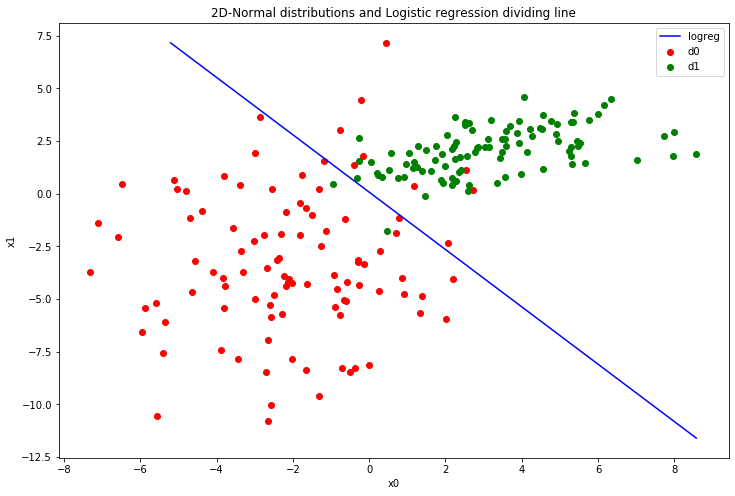

In [12]:
plt.figure(figsize=(12,8))
plt.scatter(d0_x0, d0_x1, c='red', label = 'd0')
plt.scatter(d1_x0, d1_x1, c='green', label = 'd1')
plt.plot([d_x0_max, l_x0], [l_x1, d_x1_max], c='blue', label='logreg')
plt.xlabel('x0')
plt.ylabel('x1')
plt.title('2D-Normal distributions and Logistic regression dividing line')
plt.legend()
plt.show()